# Strategy 

### Initial Thoughts 
1. Decomposition of date - Seasonality, trend, residuals 
1. Date formater
 * weekend indicator - use https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298202
 * Summer / Winter / Autumn / Spring
 * days till next holiday/ Season (christmas, easter?)
 * public holidays dataset **NB**
1. Create a model for each county / store type / product type 
1. Day and season lags 

### Multi-step strategy 
1. Direct Multi-step Forecast Strategy - model for each step
1. Recursive Multi-step Forecast Strategy.
1. Direct-Recursive Hybrid Multi-step Forecast Strategies.
1. Multiple Output Forecast Strategy.

# Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import lightgbm as lgb 
from sklearn.linear_model import LinearRegression,HuberRegressor,SGDRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import seaborn as sns
from catboost import CatBoostRegressor,Pool

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit
import optuna
import xgboost as xgb

In [3]:
PRODUCT_SPLIT= False
Date_Augmentation = True

HOLIDAYS = True

NUM_TRIALS = 200

In [4]:
NUM_SPLITS = 10
EPOCHS = 100
EARLY_STOPPING = 200

#OPTUNA 
DEVICE = "cpu"
METRIC = 'tweedie' # poisson rmse mape huber tweedie 
OBJECTIVE = "tweedie" # poisson regression mape, huber  tweedie 
BOOSTING =  'gbdt'  # "goss" 'dart'  'gbdt'

SCALER_NAME = "Minmax"  #None MinMax
SCALER = MinMaxScaler() 

MODEL_TYPE = "lightgbm"#"catboost" #lightgbm

# Load Data

In [5]:
train = pd.read_csv("../input/tabular-playground-series-jan-2022/train.csv",index_col = 0)
test = pd.read_csv("../input/tabular-playground-series-jan-2022/test.csv",index_col = 0)

if HOLIDAYS:
    holidays = pd.read_csv("../input/holidays-finland-norway-sweden-20152019/Holidays_Finland_Norway_Sweden_2015-2019.csv",usecols = ["Date","Country","Name"]                      )
    holidays.rename(columns = {"Date":"date","Country":"country","Name":"holiday"},inplace= True)
    holidays["holiday"]= 1
    holidays["holiday"]= holidays["holiday"].astype("int32")
    holidays["date"] = pd.to_datetime(holidays["date"])

In [6]:
 holidays.sample(6)

,date,country,holiday
200,2019-01-06,Sweden,1
35,2017-05-01,Finland,1
52,2018-05-20,Finland,1
146,2015-10-31,Sweden,1
18,2016-03-27,Finland,1
171,2017-04-17,Sweden,1


In [7]:
#Make date
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

In [8]:
def public_hols(df):
    df = pd.merge(df, holidays, how='left', on=['date', 'country'])
    df.fillna(value = 0,inplace=True)
    
    return df

In [9]:
def DateProcessor(df):
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    
    df['dayofyear'] = df['date'].dt.dayofyear
    df['inverse_dayofyear'] = 365 - df['dayofyear']
    
    
    #df["day_sin"] = df["date"].apply(lambda x: np.sin(2*np.pi*x.day/31))
    #df["day_cos"] = df["date"].apply(lambda x: np.cos(2*np.pi*x.day/31))
    
    #df['daysinmonth'] = df['date'].dt.days_in_month
    #df['quarter'] = df['date'].dt.quarter
    #df["weekend_ind"] = df["dayofweek"].apply(lambda x: 1 if x in [5,6] else 0)
    #df["week"] = df['date'].dt.isocalendar().week.astype(int)
    
    #df["sample_num"] = df.index    # this is a weird one
    
    return df

In [10]:
def split_product(df):
    train_mug = df[df["product"]=="Kaggle Mug"]
    train_hat = df[df["product"]=="Kaggle Hat"]
    train_sticker = df[df["product"]=="Kaggle Sticker"]
    
    return train_mug, train_hat, train_sticker

if PRODUCT_SPLIT:
    train_mug, train_hat, train_sticker = split_product(train)

In [11]:
if HOLIDAYS:
    train = public_hols(train)
    test = public_hols(test)

    train = DateProcessor(train)
    test = DateProcessor(test)

In [12]:
#Create the train and test data set
train.index = train["date"]
train.drop("date",axis=1,inplace=True)

test.index = test["date"]
test.drop("date",axis=1,inplace=True)

In [13]:
train.sample()

,country,store,product,num_sold,holiday,day,dayofweek,month,year,dayofyear,inverse_dayofyear
date,,,,,,,,,,,
2017-06-23,Finland,KaggleMart,Kaggle Sticker,102,1.0,23,4,6,2017,174,191


# Functions 
As oer discussion and post by 
https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298202

In [14]:
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [15]:
# Alternative to feature engineering functions

#create lag feature with noise
def lag_features(dataframe, lags, group_list = [], target = None ):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['target_lag_' + str(lag)] = dataframe.groupby(group_list)[target].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [16]:
def roll_mean_features(dataframe, windows, group_list = [], target = None ):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['target_roll_mean_' + str(window)] = dataframe.groupby(group_list)[targte]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [17]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [18]:
#Scaler takes the following inputs, train_features, train_labeles and test data
def scale_data(X_train, X_val):
    scaler= SCALER
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    
    return X_train, X_val

In [19]:
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

In [20]:
train.shape

(26298, 11)

In [21]:
train = lag_features(dataframe = train, lags = [1,12], group_list = ["country", "store", "product"], target = "num_sold")

In [22]:
train.shape

(26298, 13)

## Products 

In [23]:
product_list= list(train["product"].unique())

### One HotEncoder

In [24]:
# Encode the feature variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [25]:
train.head()

,num_sold,holiday,day,dayofweek,month,year,dayofyear,inverse_dayofyear,target_lag_1,target_lag_12,country_Finland,country_Norway,country_Sweden,store_KaggleMart,store_KaggleRama,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker
date,,,,,,,,,,,,,,,,,,
2015-01-01,329,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,0,1,0
2015-01-01,520,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,1,0,0
2015-01-01,146,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,0,0,1
2015-01-01,572,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,0,1,0,1,0
2015-01-01,911,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,0,1,1,0,0


### Splitting

In [26]:
tscv = TimeSeriesSplit(max_train_size=None, n_splits=NUM_SPLITS)

### Setting up the train and test data sets

##### Consider adding a plot function which shows the time series split visually

In [27]:
# X train_features without the target, y = train labels
train_features= train.drop("num_sold", axis=1)
train_label= train["num_sold"]

In [28]:
train_features.head()

,holiday,day,dayofweek,month,year,dayofyear,inverse_dayofyear,target_lag_1,target_lag_12,country_Finland,country_Norway,country_Sweden,store_KaggleMart,store_KaggleRama,product_Kaggle Hat,product_Kaggle Mug,product_Kaggle Sticker
date,,,,,,,,,,,,,,,,,
2015-01-01,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,0,1,0
2015-01-01,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,1,0,0
2015-01-01,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,1,0,0,0,1
2015-01-01,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,0,1,0,1,0
2015-01-01,1.0,1,3,1,2015,1,364,NaN,NaN,1,0,0,0,1,1,0,0


In [29]:
train_features.shape

(26298, 17)

### Feature importance

# Model Creation and CROSS VAL

In [30]:
# Create a fitted model
def lgbm_model(params, X_train,y_train,X_val,y_val):
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    val_data =lgb.Dataset(X_val,label=y_val )
    
 
    model = lgb.train(params=params,
                          train_set= train_data, 
                          num_boost_round= EPOCHS,
                          valid_sets= [val_data], 
                          callbacks=[lgb.early_stopping(EARLY_STOPPING)],
                         )
          
    return model

In [31]:
# Create a fitted model
def create_model(params, X_train,y_train,X_val,y_val, model_type = "lightgbm"):
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    val_data =lgb.Dataset(X_val,label=y_val )
    
    ## CREATE lightgbm model
    if model_type =="lightgbm":
        model = lgb.train(params=params,
                          train_set= train_data, 
                          num_boost_round= EPOCHS,
                          valid_sets= [val_data], 
                          callbacks=[lgb.early_stopping(EARLY_STOPPING)],
                         )
        
    elif model_type == "catboost":
        
        model = CatBoostRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=EARLY_STOPPING)

    else:
        model = xgb.XGBClassifier(**params)
        
    return model


In [32]:
# Create a function that performs the cross validation 
def cross_val_lgbm(train_features,train_label, tscv, params):
    
    scores = []
    #test_predictions = np.zeros(len(test))

    for idx, (train_index, val_index) in enumerate(tscv.split(train_features)):

        print(f"########################## Fold {idx+1} with  #########################")
              
        X_train, X_val = train_features.iloc[train_index,:], train_features.iloc[val_index,:]
        y_train, y_val = train_label[train_index], train_label[val_index]

        print("CV Split from: ", X_train.index.min(), "to ",X_train.index.max())
        print("Val Split from: ", X_val.index.min(), "to ",X_val.index.max())

        if SCALER_NAME !="None":
            print(f"Scaling with {SCALER_NAME}")
            X_train,X_val = scale_data(X_train,X_val)
        #else:
            #test_scaled = test_df

        model = lgbm_model(params, X_train,y_train,X_val,y_val)
        
        del X_train
        del y_train

        preds_valid = model.predict(X_val)
        smape = SMAPE(y_val,  preds_valid)
        print("Smape Score:", smape )
        print("RMSE: ", mean_squared_error(y_val,preds_valid)**0.5)
        
        scores.append(smape)

        del X_val
        del y_val

        
    return  scores, model

In [33]:
# Create a function that performs the cross validation 
def cross_val(train_features,train_label, tscv, params):
    
    scores = []
    #test_predictions = np.zeros(len(test))

    for idx, (train_index, val_index) in enumerate(tscv.split(train_features)):

        print(f"########################## Fold {idx+1} with {MODEL_TYPE} #########################")
              
        X_train, X_val = train_features.iloc[train_index,:], train_features.iloc[val_index,:]
        y_train, y_val = train_label[train_index], train_label[val_index]

        print("CV Split from: ", X_train.index.min(), "to ",X_train.index.max())
        print("Val Split from: ", X_val.index.min(), "to ",X_val.index.max())

        if SCALER_NAME !="None":
            print(f"Scaling with {SCALER_NAME}")
            X_train,X_val = scale_data(X_train,X_val)
        #else:
            #test_scaled = test_df

        model = create_model(params, X_train,y_train,X_val,y_val, model_type = MODEL_TYPE)
        
        del X_train
        del y_train

        preds_valid = model.predict(X_val)
        smape = SMAPE(y_val,  preds_valid)
        print("Smape Score:", smape )
        print("RMSE: ", mean_squared_error(y_val,preds_valid)**0.5)
        
        scores.append(smape)

        del X_val
        del y_val

        
    return  scores, model

# Apply the Pipeline

In [34]:
# Define the default hyperparameter

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 50,
              'nthread': -1}

In [35]:
cross_val_results, model  = cross_val_lgbm(train_features = train_features,train_label = train_label, tscv = tscv, params = lgb_params)

########################## Fold 1 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2015-05-14 00:00:00
Val Split from:  2015-05-14 00:00:00 to  2015-09-23 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 6.557492985386566
RMSE:  33.98015117182318
########################## Fold 2 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2015-09-23 00:00:00
Val Split from:  2015-09-24 00:00:00 to  2016-02-03 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 6.742535283763464
RMSE:  54.41596397073856
########################## Fold 3 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2016-02-03 00:00:00
Val Split from:  2016-02-03 00:00:00 to  2016-06-15 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.904942913214207
RMSE:  35.849689750561055
########################## Fold 4 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2016-06-15 00:00:00
Val Split from:  2016-06-15 00:00:00 to  2016-10-26 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.494814915084579
RMSE:  25.998305115924037
########################## Fold 5 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2016-10-26 00:00:00
Val Split from:  2016-10-26 00:00:00 to  2017-03-08 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.80976234904049
RMSE:  39.56979281857548
########################## Fold 6 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2017-03-08 00:00:00
Val Split from:  2017-03-08 00:00:00 to  2017-07-18 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.872424869141455
RMSE:  38.23399302955119
########################## Fold 7 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2017-07-18 00:00:00
Val Split from:  2017-07-18 00:00:00 to  2017-11-28 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.380903509327368
RMSE:  26.619392126655043
########################## Fold 8 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2017-11-28 00:00:00
Val Split from:  2017-11-28 00:00:00 to  2018-04-10 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.853733432575576
RMSE:  51.699526213108875
########################## Fold 9 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2018-04-10 00:00:00
Val Split from:  2018-04-10 00:00:00 to  2018-08-21 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.879475983139426
RMSE:  36.120641986211076
########################## Fold 10 with  #########################
CV Split from:  2015-01-01 00:00:00 to  2018-08-21 00:00:00
Val Split from:  2018-08-21 00:00:00 to  2018-12-31 00:00:00
Scaling with Minmax
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002225 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Smape Score: 5.266201187324745
RMSE:  34.64194697012162


In [36]:
 np.mean(cross_val_results)

5.876228742799788

In [37]:
model.params

{'metric': {'mae'},
 'num_leaves': 10,
 'learning_rate': 0.02,
 'feature_fraction': 0.8,
 'max_depth': 5,
 'verbose': 0,
 'nthread': -1,
 'num_iterations': 15000,
 'early_stopping_round': 50}

In [43]:
def plot_lgb_importances(model,plot=True,num=10):
    
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    print(feat_imp.head(num))

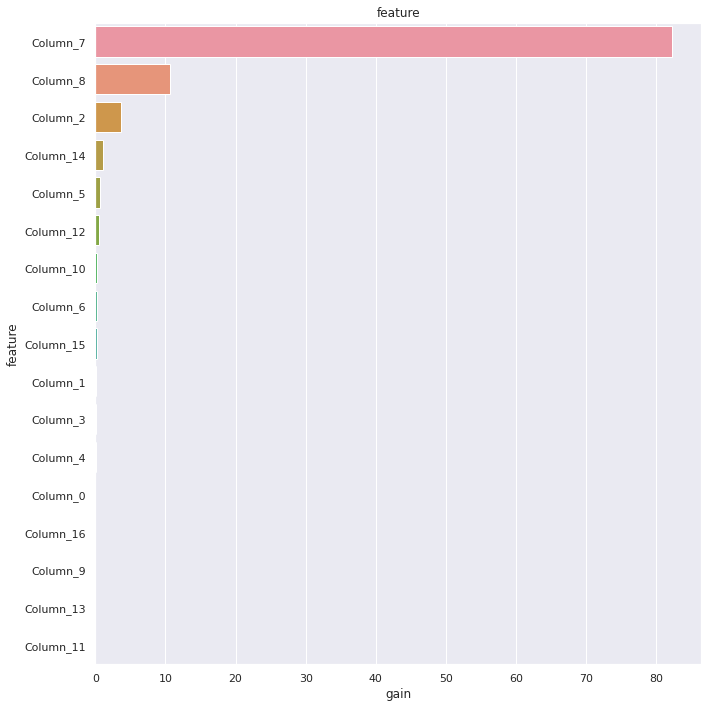

      feature  split       gain
7    Column_7   8457  82.312569
8    Column_8   6067  10.708897
2    Column_2   3724   3.701961
14  Column_14   1226   1.147572
5    Column_5   5769   0.691401
12  Column_12    917   0.473949
10  Column_10    973   0.305912
6    Column_6   3111   0.216497
15  Column_15    108   0.179200
1    Column_1   3041   0.104975


In [44]:
plot_lgb_importances(model)

In [46]:
model.feature_name()

['Column_0',
 'Column_1',
 'Column_2',
 'Column_3',
 'Column_4',
 'Column_5',
 'Column_6',
 'Column_7',
 'Column_8',
 'Column_9',
 'Column_10',
 'Column_11',
 'Column_12',
 'Column_13',
 'Column_14',
 'Column_15',
 'Column_16']

# Optuna 

## Catboost

In [79]:
def objective_cat(trial,cv=tscv, cv_fold_func=np.average):
    params = {}
    params['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001)
    params['depth'] = trial.suggest_int('depth', 6, 12)
    params['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    params['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    params['grow_policy'] = 'Depthwise'
    params['iterations'] = EPOCHS
    params['use_best_model'] = True
    params['eval_metric'] = 'RMSE'
    params['od_type'] = 'iter'
    params['od_wait'] = 20
    params['random_state'] = 42
    params['logging_level'] = 'Silent'

    test_predictions , scores = cross_val(X,test,tscv, params)
    
    return np.mean(scores)

## XGBOOST

In [80]:
def objective_xgb(trial,cv=tscv, cv_fold_func=np.average):

    # Optuna suggest params
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 0.90),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 0.90),
        'gamma': trial.suggest_int('gamma', 0, 20),
        'missing': -999,
        #'tree_method': 'gpu_hist'  
    }
    
    pipe = Pipeline(steps=[
        ('scaler', SCALER),
        ('xgb', xgb.XGBRFRegressor(**params))
    ])
    scores= []
    for idx, (train_index, test_index) in enumerate(tscv.split(X)):
    
        print(f"########################## Fold {idx+1} #########################")

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        print("CV Split from: ", X_train.index.min(), "to ",X_train.index.max())
        print("Val Split from: ", X_test.index.min(), "to ",X_test.index.max())

        pipe.fit(X_train,y_train)
        
        del X_train
        del y_train
        
        preds_valid = pipe.predict(X_test)
        smape = SMAPE(y_test,  preds_valid)
        print("Smape Score:" , smape)
        print("RMSE:", mean_squared_error(y_test,preds_valid)**0.5)

        scores.append(smape)

        del X_test
        del y_test

    return cv_fold_func(scores)

### Lightgbm

In [81]:
def objective_lgb(trial,cv=tscv, cv_fold_func=np.average):
    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
        'objective': OBJECTIVE,
        'metric': METRIC,
        "num_threads": -1,
        "verbose" : -1,
        "boosting_type":BOOSTING,
        "learning_rate": trial.suggest_float('learning_rate',0.01,0.2),
        #'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        #'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_bin': trial.suggest_int('max_bin', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2,15),
    }
    scores= []
    for idx, (train_index, test_index) in enumerate(tscv.split(X)):
    
        print(f"########################## Fold {idx+1} #########################")

        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        print("CV Split from: ", X_train.index.min(), "to ",X_train.index.max())
        print("Val Split from: ", X_test.index.min(), "to ",X_test.index.max())

        train_data = lgb.Dataset(X_train, label=y_train,)
        test_data =lgb.Dataset(X_test,label=y_test )

        del X_train
        del y_train

      
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, METRIC)

        model = lgb.train(params=params,
                          train_set= train_data, 
                          num_boost_round= EPOCHS,
                          valid_sets= [test_data], 
                          callbacks=[pruning_callback,
                                     lgb.log_evaluation(0), 
                                     lgb.early_stopping(30)],
                         )

        preds_valid = model.predict(X_test)
        smape = SMAPE(y_test,  preds_valid)
        print("Smape Score:" , smape)
        print("RMSE:", mean_squared_error(y_test,preds_valid)**0.5)

        scores.append(smape)

        del X_test
        del y_test

    return cv_fold_func(scores)

# Run Optuna

In [82]:
study = optuna.create_study(direction="minimize")
if MODEL_TYPE == "lightgbm":
    print("RUNNINING LIGHTGBM")
    study.optimize(objective_lgb, n_trials=NUM_TRIALS)

elif MODEL_TYPE == "xgboost":
    print("RUNNINING XGBOOST")
    study.optimize(objective_xgb, n_trials=NUM_TRIALS)
    
    
elif MODEL_TYPE == "catboost":
    study.optimize(objective_cat, n_trials=NUM_TRIALS)
trial = study.best_trial

[I 2023-02-19 17:59:33,507] A new study created in memory with name: no-name-2dd7a258-7558-41e5-a008-7942ef820fa1
[W 2023-02-19 17:59:33,510] Trial 0 failed because of the following error: NameError("name 'X' is not defined")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_182/1107582958.py", line 17, in objective_lgb
    for idx, (train_index, test_index) in enumerate(tscv.split(X)):
NameError: name 'X' is not defined


RUNNINING LIGHTGBM


NameError: name 'X' is not defined

In [ ]:
#Print our results
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial num :",trial.number)
print(" SMAPE Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))